In [170]:
# 1. Načítanie knižníc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Funkcie na výpočty ---
def moving_average_derivative(values, window_size=5):
    return np.diff(np.convolve(values, np.ones(window_size)/window_size, mode='valid'))

def second_derivative(values):
    first_derivative = np.diff(values)
    return np.diff(first_derivative)

def second_moving_average_derivative(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return second_derivative(moving_avg)

def max_moving_average(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return np.max(np.abs(moving_avg))

def compute_metrics(df):
    metrics = []
    
    for chance_id, group in df.groupby("chance_id"):
        values = group["value"].values

        max_abs_value = np.max(np.abs(values))
        min_max_diff = np.abs(np.max(values) - np.min(values))
        top_10_avg = np.mean(np.sort(np.abs(values))[-10:])
        first_derivative = np.abs(np.diff(values))
        max_derivative = np.max(first_derivative)
        second_derivative_vals = np.abs(second_derivative(values))
        max_second_derivative = np.max(second_derivative_vals)
        moving_avg_derivative = np.abs(moving_average_derivative(values))
        max_moving_avg_derivative = np.max(moving_avg_derivative)
        second_moving_avg_derivative_vals = np.abs(second_moving_average_derivative(values))
        max_second_moving_avg_derivative = np.max(second_moving_avg_derivative_vals)
        max_moving_value = np.abs(max_moving_average(values))
        
        metrics.append({
            "chance_id": chance_id,
            "max_abs_value": max_abs_value,
            "top_10_avg": top_10_avg,
            "min_max_diff": min_max_diff,
            "max_derivative": max_derivative,
            "max_second_derivative": max_second_derivative,
            "max_moving_derivative": max_moving_avg_derivative,
            "max_second_moving_derivative": max_second_moving_avg_derivative,
            "max_moving_value": max_moving_value,
            "true_label": group["chance"].iloc[0]  # Predpokladáme, že všetky rovnaké
        })
    
    return pd.DataFrame(metrics)

def compute_error_rates(y_true, y_pred_scores, thresholds):
    fpr_list = []
    fnr_list = []
    for t in thresholds:
        preds = y_pred_scores > t
        tp = np.sum((preds == 1) & (y_true == 1))
        fp = np.sum((preds == 1) & (y_true == 0))
        fn = np.sum((preds == 0) & (y_true == 1))
        tn = np.sum((preds == 0) & (y_true == 0))
        
        fpr = fp / (fp + tn + 1e-8)
        fnr = fn / (fn + tp + 1e-8)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
    return np.array(fpr_list), np.array(fnr_list)


def plot_error_rates(thresholds, fpr, fnr, y_true, y_pred_scores):
    fig, ax1 = plt.subplots(figsize=(12, 7))

    fpr = np.array(fpr)
    fnr = np.array(fnr)

    # Vyhladenie FPR a FNR pomocou Savitzky-Golay filtra
    window_length = 11 if len(fpr) >= 11 else (len(fpr) // 2) * 2 + 1  # Musí byť nepárne
    polyorder = 2 if window_length > 2 else 1

    smooth_fpr = savgol_filter(fpr, window_length=window_length, polyorder=polyorder)
    smooth_fnr = savgol_filter(fnr, window_length=window_length, polyorder=polyorder)

    ax1.plot(thresholds, smooth_fpr, label="False Positive Rate (FPR)", color='red')
    ax1.plot(thresholds, smooth_fnr, label="False Negative Rate (FNR)", color='blue')

    diff = np.abs(fpr - fnr)
    threshold_selected = thresholds[np.argmin(diff)]

    ax1.axvline(threshold_selected, color='black', linestyle='--', label=f"Threshold = {threshold_selected:.2f}")
    ax1.axhline(smooth_fpr[np.argmin(diff)], color='black', linestyle='--', label=f"Error at Threshold = {smooth_fpr[np.argmin(diff)]:.2f}")

    ax1.set_xlabel("Classification Score")
    ax1.set_ylabel("Error rate")
    ax1.set_title("FPR / FNR vs Classification Score")
    ax1.grid(True)

    scatter_colors = ['blue' if label == 1 else 'red' for label in y_true]
    ax1.scatter(y_pred_scores, y_true, color=scatter_colors, s=30, alpha=0.5)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10), 
                                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)], 
               labels=labels + ['Samples (True=1 - Chance)', 'Samples (True=0 - No Chance)'], loc="upper right", bbox_to_anchor=(1, 0.75))

    plt.show()

    # Výpočet metrík pre zvolený threshold
    y_pred = (y_pred_scores > threshold_selected).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\nMetrics at threshold = {threshold_selected:.2f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    




    

def plot_roc_curve_all_metrics(y_true, y_pred_scores_dict):
    plt.figure(figsize=(8, 8))

    for metric_name, y_pred_scores in y_pred_scores_dict.items():
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores)
        roc_auc = auc(fpr, tpr)

        # Vyhladenie kriviek pomocou Savitzky-Golay filtra
        window_length = 11 if len(fpr) >= 11 else (len(fpr) // 2) * 2 + 1  # Musí byť nepárne
        polyorder = 2 if window_length > 2 else 1

        smooth_fpr = savgol_filter(fpr, window_length=window_length, polyorder=polyorder)
        smooth_tpr = savgol_filter(tpr, window_length=window_length, polyorder=polyorder)

        # Vykreslenie ROC krivky
        plt.plot(smooth_fpr, smooth_tpr, lw=2, label=f"{metric_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - All Metrics")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



In [172]:
from scipy.spatial.distance import euclidean, cosine, cityblock
from scipy.stats import pearsonr
from fastdtw import fastdtw

def compare_to_avg_all_metrics(avg_sanca, avg_nesanca, df):
    results = []
    grouped = df.groupby("chance_id")["abs_value"].apply(lambda x: x.values)

    for chance_id, values in grouped.items():
        # L2 distance (Euclidean)
        l2_sanca = euclidean(values, avg_sanca)
        l2_nesanca = euclidean(values, avg_nesanca)
        l2_score = l2_nesanca - l2_sanca

        # L1 (Manhattan)
        l1_sanca = cityblock(values, avg_sanca)
        l1_nesanca = cityblock(values, avg_nesanca)
        l1_score = l1_nesanca - l1_sanca

        # Pearson correlation
        corr_sanca, _ = pearsonr(values, avg_sanca)
        corr_nesanca, _ = pearsonr(values, avg_nesanca)
        pearson_score = corr_sanca - corr_nesanca

        # Cosine similarity
        cos_sanca = 1 - cosine(values, avg_sanca)
        cos_nesanca = 1 - cosine(values, avg_nesanca)
        cosine_score = cos_sanca - cos_nesanca

        # DTW distance using fastdtw
        dtw_sanca, _ = fastdtw(values, avg_sanca, dist=euclidean)
        dtw_nesanca, _ = fastdtw(values, avg_nesanca, dist=euclidean)
        dtw_score = dtw_nesanca - dtw_sanca

        # Pridáme true label
        true_label = df[df["chance_id"] == chance_id]["chance"].iloc[0]

        results.append({
            "chance_id": chance_id,
            "true_label": true_label,
            "l2_score": l2_score,
            "l1_score": l1_score,
            "pearson_score": pearson_score,
            "cosine_score": cosine_score,
            "dtw_score": dtw_score
        })

    # Vrátime výsledky ako DataFrame
    return pd.DataFrame(results)

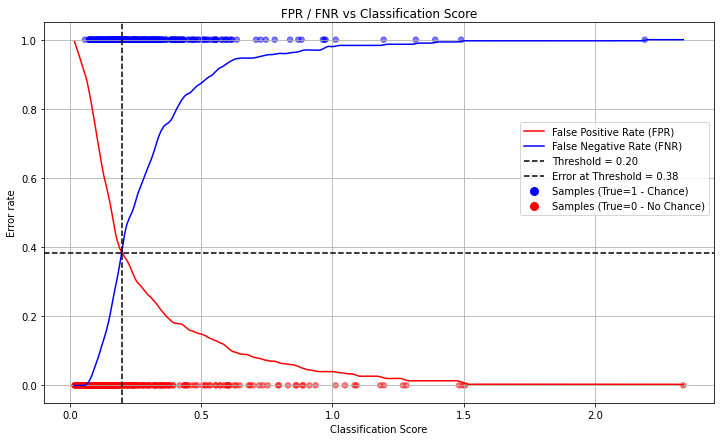


Metrics at threshold = 0.20
Accuracy : 0.6073
Precision: 0.6081
Recall   : 0.6000
F1 Score : 0.6040


In [173]:
# 1. Načítanie CSV
df1 = pd.read_csv("../.scratch/all_predictions_fs2_lr_gamma_up2.csv")
df2 = pd.read_csv("../.scratch/all_predictions_fs2_no_true.csv")

# 2. Predspracovanie
for df in [df1, df2]:
    df["base_filename"] = df["filename"].str.extract(r"(instance_\d+)_")
    df["chance_id"] = df['chance'].astype(str) + '_' + df["base_filename"] + "_" + df["bool"].astype(str) + "_" + df["side"]

# 3. Spočítanie metrík
metrics_df = compute_metrics(df1)

# 4. Príprava ground-truth a skóre
y_true = metrics_df["true_label"].values
# Vyber si, ktoré skóre chceš použiť ako predikciu:
y_pred_scores = metrics_df["top_10_avg"].values

# 5. Výpočet chybovosti pre rôzne thresholdy
thresholds = np.linspace(y_pred_scores.min(), y_pred_scores.max(), 500)
fpr, fnr = compute_error_rates(y_true, y_pred_scores, thresholds)

# 6. Vykreslenie FPR/FNR + bodky
plot_error_rates(thresholds, fpr, fnr, y_true, y_pred_scores)



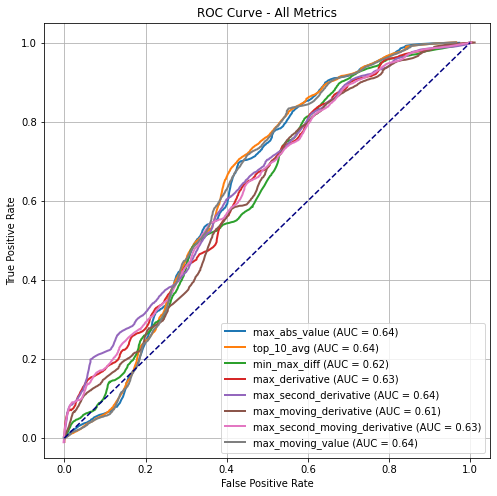

In [174]:
y_pred_scores_dict = {
    "max_abs_value": metrics_df["max_abs_value"].values,
    "top_10_avg": metrics_df["top_10_avg"].values,
    "min_max_diff": metrics_df["min_max_diff"].values,
    "max_derivative": metrics_df["max_derivative"].values,
    "max_second_derivative": metrics_df["max_second_derivative"].values,
    "max_moving_derivative": metrics_df["max_moving_derivative"].values,
    "max_second_moving_derivative": metrics_df["max_second_moving_derivative"].values,
    "max_moving_value": metrics_df["max_moving_value"].values
}


plot_roc_curve_all_metrics(y_true, y_pred_scores_dict)

In [175]:
# Pridanie stĺpca s absolútnou hodnotou
df1["abs_value"] = df1["value"].abs()
df2["abs_value"] = df2["value"].abs()

# Pre šance
sanca_matrix = df1[df1["chance"] == True].groupby("chance_id")["abs_value"].apply(lambda x: x.values).to_list()
sanca_matrix = np.vstack(sanca_matrix)  # Každý riadok = jedna akcia
avg_sanca = np.mean(sanca_matrix, axis=0)  # Priemer po stĺpcoch

# Pre nešance
nesanca_matrix = df1[df1["chance"] == False].groupby("chance_id")["abs_value"].apply(lambda x: x.values).to_list()
nesanca_matrix = np.vstack(nesanca_matrix)
avg_nesanca = np.mean(nesanca_matrix, axis=0)

# Vypočítať metriky pre všetky sekvencie
df_metrics2 = compare_to_avg_all_metrics(avg_sanca, avg_nesanca, df1)

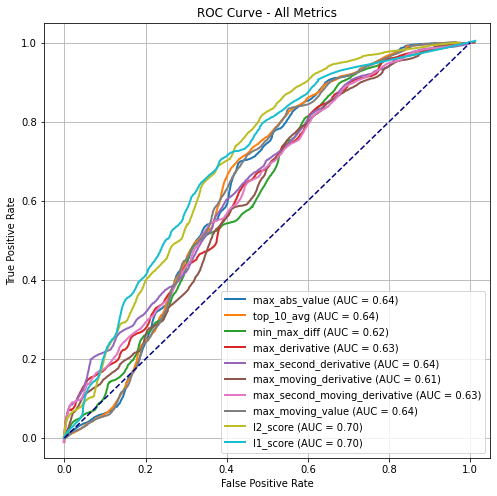

In [176]:
# Predpokladám, že df_metrics2 je už vytvorené z nových metrík
y_pred_scores_dict2 = {
    "l2_score": df_metrics2["l2_score"].values,
    "l1_score": df_metrics2["l1_score"].values,
    "pearson_score": df_metrics2["pearson_score"].values,
    "cosine_score": df_metrics2["cosine_score"].values,
    "dtw_score": df_metrics2["dtw_score"].values,
}
y_pred_scores_dict = {
    "max_abs_value": metrics_df["max_abs_value"].values,
    "top_10_avg": metrics_df["top_10_avg"].values,
    "min_max_diff": metrics_df["min_max_diff"].values,
    "max_derivative": metrics_df["max_derivative"].values,
    "max_second_derivative": metrics_df["max_second_derivative"].values,
    "max_moving_derivative": metrics_df["max_moving_derivative"].values,
    "max_second_moving_derivative": metrics_df["max_second_moving_derivative"].values,
    "max_moving_value": metrics_df["max_moving_value"].values,
    "l2_score": df_metrics2["l2_score"].values,
    "l1_score": df_metrics2["l1_score"].values
}


plot_roc_curve_all_metrics(y_true, y_pred_scores_dict)

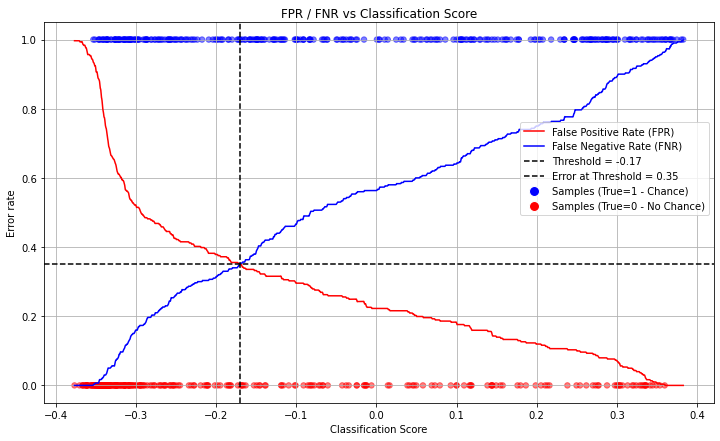


Metrics at threshold = -0.17
Accuracy : 0.6473
Precision: 0.6467
Recall   : 0.6467
F1 Score : 0.6467


In [177]:
# 4. Príprava ground-truth a skóre
y_true = df_metrics2["true_label"].values

y_pred_scores = df_metrics2["l2_score"].values

# 5. Výpočet chybovosti pre rôzne thresholdy
thresholds = np.linspace(y_pred_scores.min(), y_pred_scores.max(), 5000)
fpr, fnr = compute_error_rates(y_true, y_pred_scores, thresholds)

# 6. Vykreslenie FPR/FNR + bodky
plot_error_rates(thresholds, fpr, fnr, y_true, y_pred_scores)

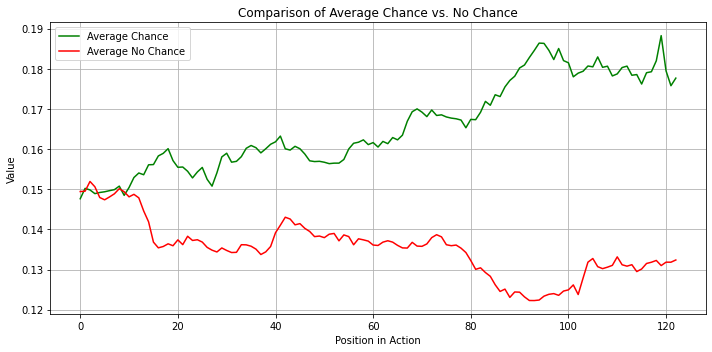

In [178]:
plt.figure(figsize=(10, 5))
plt.plot(avg_sanca, label="Average Chance", color="green")
plt.plot(avg_nesanca, label="Average No Chance", color="red")
plt.xlabel("Position in Action")
plt.ylabel("Value")
plt.title("Comparison of Average Chance vs. No Chance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()